In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow
# %%
from skimage.transform import resize
from tqdm import tqdm
from tensorflow import keras
import cv2
import random

In [2]:
def Heatmapgen(x):
    #https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea referred from here
    group_names = ['True -ve','False +ve','False -ve','True +ve']
    group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

In [3]:
'''Construct a data generator using tf.Dataset'''
def convert_to_tf_dataset(images, labels, batch_size=64):
    # TODO: apply some augmentation (rotation, flipping)

    def normalize(input_image):
        input_image = tf.cast(input_image, tf.float32) / 255.0
        return input_image

    def load_image(datapoint):
        input_image = normalize(datapoint['image'])
        return input_image, datapoint['mask_pres']

    dataset = tf.data.Dataset.from_tensor_slices({'image': images, 'mask_pres': labels})
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    batches = (dataset.cache().shuffle(100).batch(batch_size).repeat().prefetch(buffer_size=tf.data.AUTOTUNE))

    return batches

In [4]:
# img size should be between 75 and image size
def get_train_test_data(split_percent=0.2, img_size=75):
    print("X_train, X_valid, y_train, y_valid generating...")

    #loading the dataframe containing images after removing conflicting images
    df=pd.read_csv('../train_masks.csv')
    img=pd.read_csv('../dup_rem.csv')
    img.drop('Unnamed: 0',axis=1,inplace=True)
    img.image_name=img.image_name.astype(int)
    img.subject_name=img.subject_name.astype(int)
    img.columns=['image_path','img','subject','mask_path']
    new_df=pd.merge(img,df,on=['img','subject'])
    new_df.pixels.fillna(0,inplace=True)
    val=[0 if i==0 else 1 for i in new_df.pixels]
    new_df['mask_pres']=val
    new_df.head(10)

    #Get array of all images based on their path
    X = []
    for path in tqdm(new_df.image_path):
        img1=cv2.imread("../raw/"+str(path),cv2.IMREAD_GRAYSCALE)
        img1=resize(np.reshape(img1, (np.shape(img1)[0], np.shape(img1)[1],1)), (img_size, img_size))
        X.append(img1)

    return train_test_split(X, new_df.mask_pres, test_size=split_percent, random_state=42)

In [5]:
def load_model_clf(val_tf_dataset, val_batch_size, val_steps_per_epoch):
    model_clf = load_model("models/clf")
    # Evaluate the restored model
    results = model_clf.evaluate(val_tf_dataset, batch_size=val_batch_size, steps=val_steps_per_epoch, verbose=2)
    print("Results of evaluation:", results)
    return model_clf

In [6]:
def fit_and_save_model_clf(model_clf, train_dataset, val_dataset, epochs, train_steps_per_epoch, val_steps_per_epoch, saveto):
    result_clf = model_clf.fit(train_dataset, steps_per_epoch=train_steps_per_epoch, epochs=epochs,
                               validation_data=val_dataset,
                               validation_steps=val_steps_per_epoch, initial_epoch=0)
    model_clf.save(saveto)
    print("model saved: ", saveto)
    return model_clf

In [7]:
def create_model_clf(img_size):
    inp = Input((img_size, img_size, 1))
    conv1 = Conv2D(filters=3, kernel_size=(3, 3), padding='same')(inp)

    # using a pretrained network
    base_model = keras.applications.InceptionResNetV2(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(img_size, img_size, 3),
        include_top=False)
    base_model.trainable = False
    base_model = base_model(conv1, training=False)

    out = Flatten()(base_model)
    out = Dense(1024, activation="relu")(out)
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid")(out)
    model_clf = Model(inputs=inp, outputs=out)
    model_clf.compile(optimizer=Adam(lr=1e-8), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    model_clf.summary()
    return model_clf

In [8]:
IMG_SIZE = 128
EPOCHS = 20
TRAIN_STEPS_PER_EPOCH = 30
VAL_STEPS_PER_EPOCH = 5

In [9]:
tf.keras.backend.clear_session()
tf.keras.backend.set_image_data_format('channels_last')

In [10]:
X_train, X_valid, y_train, y_valid = get_train_test_data(0.2, IMG_SIZE)


BATCH_SIZE_TRAIN = len(y_train) // TRAIN_STEPS_PER_EPOCH
BACTH_SIZE_TEST = len(y_valid) // VAL_STEPS_PER_EPOCH

X_train, X_valid, y_train, y_valid generating...


100%|██████████| 5465/5465 [01:14<00:00, 73.61it/s]


In [11]:
train_tf_dataset = convert_to_tf_dataset(X_train,y_train, BATCH_SIZE_TRAIN)
valid_tf_dataset = convert_to_tf_dataset(X_valid,y_valid, BACTH_SIZE_TEST)

In [ ]:
print("creating model...")
model_clf = create_model_clf(IMG_SIZE)
print("training model...")
model_clf = fit_and_save_model_clf(model_clf, train_tf_dataset, valid_tf_dataset, epochs = EPOCHS, train_steps_per_epoch = TRAIN_STEPS_PER_EPOCH, val_steps_per_epoch = VAL_STEPS_PER_EPOCH, saveto = "models/clf")

In [12]:
print("loading_model...")
model_clf = load_model_clf(valid_tf_dataset, BACTH_SIZE_TEST, VAL_STEPS_PER_EPOCH)

loading_model...
5/5 - 28s - loss: 0.5093 - accuracy: 0.7550 - auc: 0.8352 - 28s/epoch - 6s/step
Results of evaluation: [0.5093324184417725, 0.7550458908081055, 0.8351656198501587]


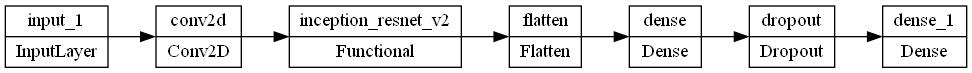

In [22]:
plot_model(model_clf, to_file='model_clf.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96)

In [13]:
'''GET STATISTICS ON THE CLF ACCURACY'''

# generate predictions on validation dataset
X_train_new=np.zeros((len(X_train),128,128,1))
X_valid_new=np.zeros((len(X_valid),128,128,1))
for i in tqdm(range(len(X_train_new))):
  X_train_new[i]=tf.cast(tf.convert_to_tensor(X_train[i]), tf.float32) / 255.0
for i in tqdm(range(len(X_valid_new))):
  X_valid_new[i] =tf.cast(tf.convert_to_tensor(X_valid[i]), tf.float32) / 255.0

pred_clf_tr=model_clf.predict(X_train_new)
pred_clf_val=model_clf.predict(X_valid_new)

#using a default threshold of 0.5 for prediction
pred_clf_val=(np.array(pred_clf_val)>0.5)
pred_clf_tr=(np.array(pred_clf_tr)>0.5)

100%|██████████| 1093/1093 [00:02<00:00, 429.51it/s]


35/35 [==============================] - 25s 701ms/step


In [16]:
from sklearn import metrics

results = metrics.accuracy_score(y_valid, pred_clf_val)
print(results)

0.7548032936870998


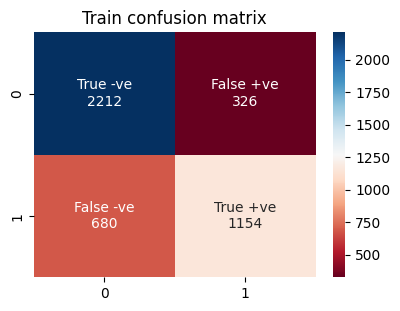

In [15]:
import seaborn as sns
#generating the confusion matrix
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
cf_matr1=confusion_matrix(y_train,pred_clf_tr)
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)

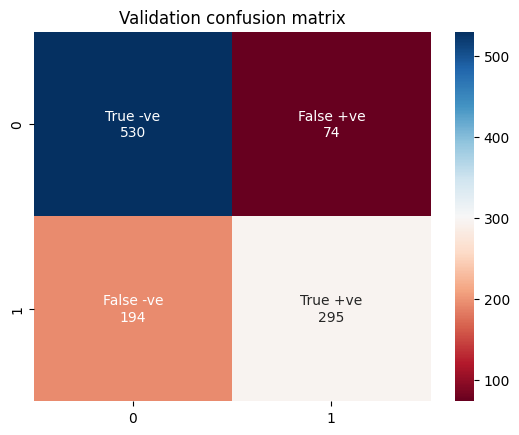

In [44]:
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_valid,pred_clf_val)
plt.title('Validation confusion matrix')
Heatmapgen(cf_matr2)

In [14]:
#storing the predictions in a list
pred_clf_val=[i[0] for i in pred_clf_val]
pred_clf_tr=[i[0] for i in pred_clf_tr]

Oversampling misclassified points

In [15]:
#getting the misclassified data points indices
wrong_pred=np.argwhere(np.where(pred_clf_tr!=y_train,1,0))
wrong_pred=[i[0] for i in wrong_pred]

In [16]:
#out of misclassified datapoints randomly sampling 500 data points
sample_indices=random.sample(wrong_pred,500)

In [20]:
print(len(y_train))
print(len(X_train))

4372
4372


In [33]:
y_valid.head(10)

5360    0
1086    0
5047    0
3617    1
2921    1
491     0
3529    1
168     1
4246    1
3213    1
Name: mask_pres, dtype: int64

In [17]:
#oversampling the train set with misclassified datapoints
X_train.extend([X_train[sample_index] for sample_index in sample_indices])
y_train = y_train.append(pd.Series([y_train.iloc[sample_index] for sample_index in sample_indices]))

C:\Users\Sasha\AppData\Local\Temp\ipykernel_7204\3115471627.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series([y_train.iloc[sample_index] for sample_index in sample_indices]))


In [23]:
print(len(y_train))
print(len(X_train))

4872
4872


In [18]:
# generating tf datasets after oversampling
train_tf_dataset = convert_to_tf_dataset(X_train, y_train, BATCH_SIZE_TRAIN)
valid_tf_dataset = convert_to_tf_dataset(X_valid, y_valid, BACTH_SIZE_TEST)

In [19]:
# Retraining the model on oversampled points
print("creating model...")
model_clf = create_model_clf(IMG_SIZE)
print("training model...")
model_clf = fit_and_save_model_clf(model_clf, train_tf_dataset, valid_tf_dataset, saveto="models/clf_improved", epochs = EPOCHS, train_steps_per_epoch = TRAIN_STEPS_PER_EPOCH, val_steps_per_epoch = VAL_STEPS_PER_EPOCH)

30/30 [==============================] - 442s 15s/step - loss: 0.6775 - accuracy: 0.5550 - auc: 0.5964 - val_loss: 0.6662 - val_accuracy: 0.5743 - val_auc: 0.7083
Epoch 8/20
30/30 [==============================] - 407s 14s/step - loss: 0.6666 - accuracy: 0.5795 - auc: 0.6165 - val_loss: 0.6763 - val_accuracy: 0.5440 - val_auc: 0.7181
Epoch 9/20
30/30 [==============================] - 421s 14s/step - loss: 0.6639 - accuracy: 0.5848 - auc: 0.6087 - val_loss: 0.6297 - val_accuracy: 0.6743 - val_auc: 0.7277
Epoch 10/20
30/30 [==============================] - 419s 14s/step - loss: 0.6591 - accuracy: 0.5843 - auc: 0.6233 - val_loss: 0.6262 - val_accuracy: 0.6550 - val_auc: 0.7349
Epoch 11/20
30/30 [==============================] - 408s 14s/step - loss: 0.6529 - accuracy: 0.5916 - auc: 0.6381 - val_loss: 0.6163 - val_accuracy: 0.6541 - val_auc: 0.7393
Epoch 12/20
 3/30 [==>...........................] - ETA: 6:06 - loss: 0.6223 - accuracy: 0.6414 - auc: 0.6945

KeyboardInterrupt: 

In [ ]:
# Epoch 3/20
# 30/30 [==============================] - 423s 14s/step - loss: 0.7097 - accuracy: 0.5047 - auc: 0.4954 - val_loss: 0.6848 - val_accuracy: 0.5514 - val_auc: 0.6784
# Epoch 4/20
# 30/30 [==============================] - 420s 14s/step - loss: 0.6912 - accuracy: 0.5263 - auc: 0.5380 - val_loss: 0.6827 - val_accuracy: 0.5532 - val_auc: 0.6801
# Epoch 5/20
# 30/30 [==============================] - 425s 14s/step - loss: 0.6850 - accuracy: 0.5436 - auc: 0.5502 - val_loss: 0.6863 - val_accuracy: 0.5523 - val_auc: 0.6808
# Epoch 6/20
# 30/30 [==============================] - 416s 14s/step - loss: 0.6853 - accuracy: 0.5356 - auc: 0.5496 - val_loss: 0.6621 - val_accuracy: 0.6174 - val_auc: 0.6911
# Epoch 7
# 30/30 [==============================] - 442s 15s/step - loss: 0.6775 - accuracy: 0.5550 - auc: 0.5964 - val_loss: 0.6662 - val_accuracy: 0.5743 - val_auc: 0.7083
# Epoch 8/20
# 30/30 [==============================] - 407s 14s/step - loss: 0.6666 - accuracy: 0.5795 - auc: 0.6165 - val_loss: 0.6763 - val_accuracy: 0.5440 - val_auc: 0.7181
# Epoch 9/20
# 30/30 [==============================] - 421s 14s/step - loss: 0.6639 - accuracy: 0.5848 - auc: 0.6087 - val_loss: 0.6297 - val_accuracy: 0.6743 - val_auc: 0.7277


In [30]:
#getting predictions using new model
pred_clf_tr=model_clf.predict(X_train_new)
pred_clf_val=model_clf.predict(X_valid_new)

35/35 [==============================] - 38s 1s/step


In [42]:
from sklearn import metrics

#using a default threshold of 0.5 for prediction
pred_clf_val_int=(np.array(pred_clf_val)>0.5)
results = metrics.accuracy_score(y_valid, pred_clf_val_int)
print(results)

0.5526075022872827


In [ ]:
#finding the best threshold on the newly trained model
#for this we calculate both the false positives and false negatives in the predictions
fp_arr_tr=[]
fn_arr_tr=[]
fp_arr_val=[]
fn_arr_val=[]
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for i in thresholds:
    pred_clf_val_=(np.array(pred_clf_val)>i)
    pred_clf_tr_=(np.array(pred_clf_tr)>i)
    cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
    cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
    fp_arr_tr.append(cf_matr1[0][1])
    fn_arr_tr.append(cf_matr1[1][0])
    fp_arr_val.append(cf_matr2[0][1])
    fn_arr_val.append(cf_matr2[1][0])

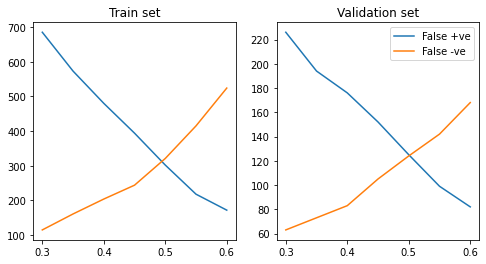

In [108]:
#plotting the fp and fn in train and validation set
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].set_title('Train set')
ax[0].plot(thresholds,fp_arr_tr,label='False +ve')
ax[0].plot(thresholds,fn_arr_tr,label='False -ve')
ax[1].set_title('Validation set')
ax[1].plot(thresholds,fp_arr_val,label='False +ve')
ax[1].plot(thresholds,fn_arr_val,label='False -ve')
plt.legend()
plt.show()

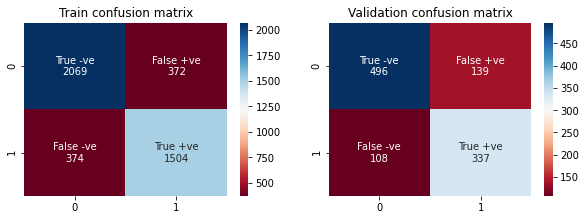

In [91]:
#0.5
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
cf_matr1=confusion_matrix(y_train,pred_clf_tr)
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_valid,pred_clf_val)
plt.title('Validation confusion matrix')
Heatmapgen(cf_matr2)

At threshold of 0.5 both fp and fn were together miniimum..